In [1]:
import os
import torch
from torch.cuda.amp import autocast, GradScaler
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import copy
import random
import multiprocessing as mp
from torch_geometric.data import HeteroData
import torch
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Enable CUDA debugging, use to block cuda calls until completion
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
device = torch.device('cpu')  # Temporarily switch to CPU

In [4]:
# Load node datasets
s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/s_emb_full_183.csv', index_col=0) # Substrates
p_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/p_emb_full_237197.csv', index_col=0) # Proteins

In [5]:
# Load edge datasets (combined with negative samples)
ppi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ppi_edges_full.csv') # Protein-Protein Interactions
ssi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ssi_edges_full.csv') # Substrate-Substrate Interactions
tp_s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_tp_s_edges_full.csv',) # Transporter Protein-Substrate Interactions

In [6]:
# Inspect and clean the data, node dataframes should be numeric
def inspect_and_clean(df):
    non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
    print(f"Non-numeric columns: {non_numeric_columns}")
    if len(non_numeric_columns) > 0:
        df[non_numeric_columns] = df[non_numeric_columns].apply(pd.to_numeric, errors='coerce')
    df = df.fillna(0)
    return df

In [7]:
# Enumerate the proteins and substrates for mapping
def get_mapping(p_dataframe, s_dataframe):
    protein_mapping = {protein_id: i for i, protein_id in enumerate(p_dataframe.index)}
    substrate_mapping = {substrate_id: i for i, substrate_id in enumerate(s_dataframe.index)}
    return protein_mapping, substrate_mapping


In [8]:
# Map the edges to the enumerated proteins and substrates
def map_edges(edge_df, source_mapping, target_mapping, edge_type):
    edge_df = edge_df.copy()

    # Apply mapping
    edge_df['source'] = edge_df['source'].map(source_mapping)
    edge_df['target'] = edge_df['target'].map(target_mapping)

    # Drop rows with NaNs in mapped columns
    edge_df.dropna(subset=['source', 'target'], inplace=True)
      
    return edge_df


In [9]:
# Apply transformations in batches, this can be useful when dealing with large 
# datasets that may not fit into memory or GPU all at once. 
def transform_in_batches(features, transform_layer, batch_size=10000):
    num_samples = features.shape[0]
    print(f"Number of samples: {num_samples}")
    transformed_features = []
    for i in range(0, num_samples, batch_size):
        batch = features[i:i + batch_size]
        batch_tensor = torch.tensor(batch, dtype=torch.float).to(device)
        transformed_batch = transform_layer(batch_tensor)
        transformed_features.append(transformed_batch.detach().cpu().numpy())  # Use detach() before numpy()
    return np.vstack(transformed_features) # Stack arrays in sequence vertically (row wise)


In [10]:
# Function to remove rows where source or target is in test_proteins or test_substrates
def filter_out_test_edges(df, protein_set, substrate_set):
    # For cases where the DataFrame has both 'source' and 'target' columns
    if 'source' in df.columns and 'target' in df.columns:
        filtered_df = df[~(df['source'].isin(protein_set) | df['target'].isin(substrate_set))]
    # For cases where the DataFrame only has an index, such as node DataFrames
    else:
        filtered_df = df[~df.index.isin(protein_set | substrate_set)]
    return filtered_df

In [11]:
def split_train_val_data(df, train_size=0.9, val_size=0.1):
    # Split into train and validation (90% train, 10% validation)
    train_df, val_df = train_test_split(df, train_size=train_size, random_state=42)
    
    return train_df, val_df


In [12]:
# Create edge index tensors for training, validation, and test
def get_tensor(df):
    return torch.tensor(df[['source', 'target']].values.T, dtype=torch.long)


In [13]:
# Labels remain the same
def get_labels(df):
    return torch.tensor(df['label'].values, dtype=torch.float)


In [14]:
s_df = inspect_and_clean(s_df)
p_df = inspect_and_clean(p_df)


Non-numeric columns: Index([], dtype='object')
Non-numeric columns: Index([], dtype='object')


In [15]:
protein_mapping, substrate_mapping = get_mapping(p_df, s_df)

In [16]:
# Apply the debugging function to map edges
mapped_ppi_edges_df = map_edges(ppi_df, protein_mapping, protein_mapping, 'PPI')
mapped_ssi_edges_df = map_edges(ssi_df, substrate_mapping, substrate_mapping, 'SSI')
mapped_tp_s_df = map_edges(tp_s_df, protein_mapping, substrate_mapping, 'TP-S')

In [17]:
print(mapped_ppi_edges_df)
print(mapped_ssi_edges_df)
print(mapped_tp_s_df)

          source  target  label
0         157025  225772      1
1         187416  234940      1
2         234940  187416      1
3         225772  100854      1
4         225772  157025      1
...          ...     ...    ...
13327041  106801   24539      0
13327042  106199  133771      0
13327043   98851   90276      0
13327044  191132   11958      0
13327045  229284  226859      0

[13327046 rows x 3 columns]
      source  target  label
0         89      17      1
1         17      89      1
2         99      78      1
3         78      99      1
4         19     129      1
...      ...     ...    ...
4349      71      33      0
4350      92      97      0
4351     140     145      0
4352      24     153      0
4353      86      81      0

[4354 rows x 3 columns]
       source  target  label
0      110150       0      1
1      113110       0      1
2       94944      63      1
3       86624      63      1
4      132714       0      1
...       ...     ...    ...
26675  121855      84  

In [18]:
from sklearn.model_selection import train_test_split

# Randomly select 50 samples for the test set from the mapped tp_s_df
test_tp_s_df = tp_s_df.sample(n=50, random_state=42)

# Remove the selected test samples from the original mapped_tp_s_df to form the training set
train_tp_s_df = tp_s_df.drop(test_tp_s_df.index)

# Check the sizes of the resulting DataFrames
print(f"Training set size: {train_tp_s_df.shape[0]}")
print(f"Test set size: {test_tp_s_df.shape[0]}")


Training set size: 26630
Test set size: 50


In [19]:
# Convert the mapped indices back to the original Uniprot IDs and ChEBI IDs
test_proteins = test_tp_s_df['source'].unique()
test_substrates = test_tp_s_df['target'].unique()

# Step 2: Split p_df into train and test based on test_proteins
p_test_df = p_df[p_df.index.isin(test_proteins)]  # Test set for proteins
p_train_df = p_df[~p_df.index.isin(test_proteins)]  # Train set for proteins

# Step 3: Split s_df into train and test based on test_substrates
s_test_df = s_df[s_df.index.isin(test_substrates)]  # Test set for substrates
s_train_df = s_df[~s_df.index.isin(test_substrates)]  # Train set for substrates

# Check the sizes of the resulting DataFrames
print(f"Protein training set size: {p_train_df.shape[0]}")
print(f"Protein test set size: {p_test_df.shape[0]}")
print(f"Substrate training set size: {s_train_df.shape[0]}")
print(f"Substrate test set size: {s_test_df.shape[0]}")


Protein training set size: 237147
Protein test set size: 50
Substrate training set size: 147
Substrate test set size: 36


In [20]:
# train_tp_s_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Edges/train_tp_s_edges.csv', index=False)
# test_tp_s_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Edges/test_tp_s_edges.csv', index=False)
# ppi_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Edges/ppi_edges.csv', index=False)
# ssi_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Edges/ssi_edges.csv', index=False)
# p_train_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Nodes/p_train.csv')
# p_test_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Nodes/p_test.csv')
# s_train_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Nodes/s_train.csv')
# s_test_df.to_csv('/data/servilla/DT_HGNN/Model/Strict_testing_datasets/STD_Nodes/s_test.csv')

In [21]:
# Convert features to numpy arrays
s_features = s_train_df.values
p_features = p_train_df.values

In [22]:
# Check shapes to ensure correct dimensions
print(f"s_features shape: {s_features.shape}")  # Expected (?, 1536)
print(f"p_features shape: {p_features.shape}")  # Expected (?, 2048)


s_features shape: (147, 1536)
p_features shape: (237147, 2048)


In [23]:
# Calculate and store training statistics
train_mean_s = np.mean(s_features, axis=0)
train_std_s = np.std(s_features, axis=0)
train_mean_p = np.mean(p_features, axis=0)
train_std_p = np.std(p_features, axis=0)

# Normalize using training statistics
s_features = (s_features - train_mean_s) / train_std_s
p_features = (p_features - train_mean_p) / train_std_p


In [24]:
# Check shapes to ensure correct dimensions
print(f"s_features shape: {s_features.shape}")  # Expected (?, 1536)
print(f"p_features shape: {p_features.shape}")  # Expected (?, 2048)


s_features shape: (147, 1536)
p_features shape: (237147, 2048)


In [25]:
# Define the transformation layers, changes the number of features 1536 -> 2048
# for substrates and 2048 -> 2048 for proteins. The transform_p layer is useful 
# for transforming the feature representation within the same dimensional space,
#  y = Wx + b.

transform_s = Linear(1536, 2048).to(device) # Change depending on the number of features
transform_p = Linear(2048, 2048).to(device)

In [26]:
# Perform the transformations in batches
s_features_transformed = transform_in_batches(s_features, transform_s)
p_features_transformed = transform_in_batches(p_features, transform_p)


Number of samples: 147
Number of samples: 237147


In [27]:
# Check shapes to ensure correct dimensions
print(f"s_features_transformed shape: {s_features_transformed.shape}")  # Expected (?, 2048)
print(f"p_features_transformed shape: {p_features_transformed.shape}")  # Expected (?, 2048)


s_features_transformed shape: (147, 2048)
p_features_transformed shape: (237147, 2048)


In [28]:
# Convert back to tensors
s_features_tensor = torch.tensor(s_features_transformed, dtype=torch.float).to(device)
p_features_tensor = torch.tensor(p_features_transformed, dtype=torch.float).to(device)


In [29]:
# Combine features, vertically stacks features (dim=0) to create a single tensor
all_features = torch.cat([p_features_tensor, s_features_tensor], dim=0)


In [30]:
print(f"all_features shape: {all_features.shape}")  # Expected (?, 2048)

all_features shape: torch.Size([237294, 2048])


In [31]:
# protein_ids = set(p_df.index)
# substrate_ids = set(s_df.index)


In [32]:
protein_mapping, substrate_mapping = get_mapping(p_train_df, s_train_df)


In [33]:
# Get the unique source and target values from test_tp_s_df
test_proteins = set(test_tp_s_df['source'].unique())
test_substrates = set(test_tp_s_df['target'].unique())


In [34]:
len(test_proteins), len(test_substrates)

(50, 36)

In [35]:
print(train_tp_s_df.shape)
print(ppi_df.shape)
print(ssi_df.shape)

(26630, 3)
(13327046, 3)
(4354, 3)


In [36]:
# Apply the function to remove rows from all DataFrames
train_tp_s_df = filter_out_test_edges(train_tp_s_df, test_proteins, test_substrates)
ppi_filtered_df = filter_out_test_edges(ppi_df, test_proteins, test_proteins)  # PPI only involves proteins
ssi_filtered_df = filter_out_test_edges(ssi_df, test_substrates, test_substrates)  # SSI only involves substrates


In [37]:
print(train_tp_s_df.shape)
print(ppi_filtered_df.shape)
print(ssi_filtered_df.shape)

(12288, 3)
(13322673, 3)
(2434, 3)


In [38]:
# Apply the debugging function to map edges
mapped_ppi_edges_df = map_edges(ppi_filtered_df, protein_mapping, protein_mapping, 'PPI')
mapped_ssi_edges_df = map_edges(ssi_filtered_df, substrate_mapping, substrate_mapping, 'SSI')
mapped_tp_s_df = map_edges(train_tp_s_df, protein_mapping, substrate_mapping, 'TP-S')


In [39]:
print(mapped_ppi_edges_df)
print(mapped_ssi_edges_df)
print(mapped_tp_s_df)

          source  target  label
0         156986  225723      1
1         187373  234890      1
2         234890  187373      1
3         225723  100833      1
4         225723  156986      1
...          ...     ...    ...
13327041  106776   24533      0
13327042  106176  133739      0
13327043   98830   90256      0
13327044  191089   11956      0
13327045  229235  226810      0

[13322673 rows x 3 columns]
      source  target  label
0         72      13      1
1         13      72      1
2         79      61      1
3         61      79      1
14       121     118      1
...      ...     ...    ...
4348      45      29      0
4349      54      25      0
4351     111     115      0
4352      17     122      0
4353      69      64      0

[2434 rows x 3 columns]
       source  target  label
13     124256      50      1
26      85773      89      1
57      93838      50      1
76      93422      50      1
79     135469       0      1
...       ...     ...    ...
26673   73793      59  

In [40]:
# Split data for each edge type (without test, as test is predefined)
ppi_train_df, ppi_val_df = split_train_val_data(mapped_ppi_edges_df)
ssi_train_df, ssi_val_df = split_train_val_data(mapped_ssi_edges_df)
tp_s_train_df, tp_s_val_df = split_train_val_data(mapped_tp_s_df)


In [41]:
# Create edge index tensors for training, validation, and test
train_edges_tp_s = torch.tensor(tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_tp_s = torch.tensor(tp_s_val_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ppi = torch.tensor(ppi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ppi = torch.tensor(ppi_val_df[['source', 'target']].values.T, dtype=torch.long)

train_edges_ssi = torch.tensor(ssi_train_df[['source', 'target']].values.T, dtype=torch.long)
val_edges_ssi = torch.tensor(ssi_val_df[['source', 'target']].values.T, dtype=torch.long)
# Labels remain the same
train_labels_tp_s = torch.tensor(tp_s_train_df['label'].values, dtype=torch.float)
val_labels_tp_s = torch.tensor(tp_s_val_df['label'].values, dtype=torch.float)

train_labels_ppi = torch.tensor(ppi_train_df['label'].values, dtype=torch.float)
val_labels_ppi = torch.tensor(ppi_val_df['label'].values, dtype=torch.float)

train_labels_ssi = torch.tensor(ssi_train_df['label'].values, dtype=torch.float)
val_labels_ssi = torch.tensor(ssi_val_df['label'].values, dtype=torch.float)


In [42]:
print(f"p_df: {p_df.shape}")
print(f"p_train_df: {p_train_df.shape}")
print(f"p_test_df: {p_test_df.shape}")
print(f"s_df: {s_df.shape}")
print(f"s_train_df: {s_train_df.shape}")
print(f"s_test_df: {s_test_df.shape}")
print(f"tp_s_df: {tp_s_df.shape}")
print(f"test_tp_s_df: {test_tp_s_df.shape}")
print(f"train_tp_s_df: {train_tp_s_df.shape}")
print(f"ppi_df: {ppi_df.shape}")
print(f"ppi_filtered_df: {ppi_filtered_df.shape}")
print(f"ssi_df: {ssi_df.shape}")
print(f"ssi_filtered_df: {ssi_filtered_df.shape}")
print(f"Training TP-S edges: {train_edges_tp_s.shape}")
print(f"Validation TP-S edges: {val_edges_tp_s.shape}")
print(f"Training PPI edges: {train_edges_ppi.shape}")
print(f"Validation PPI edges: {val_edges_ppi.shape}")
print(f"Training SSI edges: {train_edges_ssi.shape}")
print(f"Validation SSI edges: {val_edges_ssi.shape}")



p_df: (237197, 2048)
p_train_df: (237147, 2048)
p_test_df: (50, 2048)
s_df: (183, 1536)
s_train_df: (147, 1536)
s_test_df: (36, 1536)
tp_s_df: (26680, 3)
test_tp_s_df: (50, 3)
train_tp_s_df: (12288, 3)
ppi_df: (13327046, 3)
ppi_filtered_df: (13322673, 3)
ssi_df: (4354, 3)
ssi_filtered_df: (2434, 3)
Training TP-S edges: torch.Size([2, 11059])
Validation TP-S edges: torch.Size([2, 1229])
Training PPI edges: torch.Size([2, 11990405])
Validation PPI edges: torch.Size([2, 1332268])
Training SSI edges: torch.Size([2, 2190])
Validation SSI edges: torch.Size([2, 244])


In [43]:
positive_tp_s_train_df = tp_s_train_df[tp_s_train_df['label'] == 1]

train_edges_tp_s_positive = torch.tensor(positive_tp_s_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ppi_train_df = ppi_train_df[ppi_train_df['label'] == 1]

train_edges_ppi_positive = torch.tensor(positive_ppi_train_df[['source', 'target']].values.T, dtype=torch.long)

positive_ssi_train_df = ssi_train_df[ssi_train_df['label'] == 1]

train_edges_ssi_positive = torch.tensor(positive_ssi_train_df[['source', 'target']].values.T, dtype=torch.long)

In [44]:
print(f"Positive TP-S edges: {train_edges_tp_s_positive.shape}")
print(f"Positive PPI edges: {train_edges_ppi_positive.shape}")
print(f"Positive SSI edges: {train_edges_ssi_positive.shape}")


Positive TP-S edges: torch.Size([2, 1422])
Positive PPI edges: torch.Size([2, 5995805])
Positive SSI edges: torch.Size([2, 897])


In [45]:
data = HeteroData()

# Assign node features
data['protein'].x = p_features_tensor
data['substrate'].x = s_features_tensor

# Assign training edges
data['protein', 'interacts_with', 'substrate'].edge_index = train_edges_tp_s_positive #train_edges_tp_s 
data['protein', 'interacts_with', 'protein'].edge_index = train_edges_ppi_positive #train_edges_ppi 
data['substrate', 'interacts_with', 'substrate'].edge_index = train_edges_ssi_positive #train_edges_ssi 


In [46]:
# Define the model
class GCNLinkPredictor(nn.Module):
    def __init__(self, protein_dim, substrate_dim, hidden_channels):
        super(GCNLinkPredictor, self).__init__()
        # GCN layers for protein and substrate
        self.protein_conv1 = GCNConv(protein_dim, hidden_channels)
        self.substrate_conv1 = GCNConv(substrate_dim, hidden_channels)
        self.protein_conv2 = GCNConv(hidden_channels, hidden_channels)
        self.substrate_conv2 = GCNConv(hidden_channels, hidden_channels)

        # Update projection layer to match concatenated dimensions
        # self.projection_layer = nn.Linear(feature size INPUT, feature size OUTPUT)
        self.projection_layer = Linear(hidden_channels * 2, 128)  # Modify the input dimension to match z_combined


        # Link predictor remains the same
        self.link_predictor = nn.Sequential(
            nn.Linear(128, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, 1)
        )

    def encode(self, x_dict, edge_index_dict):
        # Handle protein-protein edges if available
        if ('protein', 'interacts_with', 'protein') in edge_index_dict:
            z_protein = self.protein_conv1(x_dict['protein'], edge_index_dict[('protein', 'interacts_with', 'protein')])
            z_protein = self.protein_conv2(z_protein, edge_index_dict[('protein', 'interacts_with', 'protein')])
        else:
            z_protein = x_dict['protein']  # Fallback to node features if no PPI edges

        # Handle substrate-substrate edges if available
        if ('substrate', 'interacts_with', 'substrate') in edge_index_dict:
            z_substrate = self.substrate_conv1(x_dict['substrate'], edge_index_dict[('substrate', 'interacts_with', 'substrate')])
            z_substrate = self.substrate_conv2(z_substrate, edge_index_dict[('substrate', 'interacts_with', 'substrate')])
        else:
            z_substrate = x_dict['substrate']  # Fallback to node features if no SSI edges

        # Handle transporter protein-substrate edges (TP-S) if available
        if ('protein', 'interacts_with', 'substrate') in edge_index_dict:
            # print(f"Shape of substrate embeddings: {x_dict['substrate'].shape}")
            # print(f"Shape of protein embeddings: {x_dict['protein'].shape}")
            
            # Extract the TP-S edge indices (connecting proteins to substrates)
            edge_indices = edge_index_dict[('protein', 'interacts_with', 'substrate')]
            
            # print(f"Max index in TP-S edges: {edge_indices.max()}")
            # print(f"Min index in TP-S edges: {edge_indices.min()}")
            
            # Sanity check for out-of-bounds indices
            if edge_indices[1].max() >= x_dict['substrate'].shape[0]:
                raise ValueError("Invalid substrate index in TP-S edges")
            if edge_indices[0].max() >= x_dict['protein'].shape[0]:
                raise ValueError("Invalid protein index in TP-S edges")
            
            # Extract source (protein) and target (substrate) indices separately
            protein_indices = edge_indices[0]  # Source (proteins)
            substrate_indices = edge_indices[1]  # Target (substrates)
            
            # Apply GCN layers separately to proteins and substrates using the corresponding indices
            z_protein_tp_s = self.protein_conv1(x_dict['protein'], torch.stack([protein_indices, protein_indices], dim=0))
            z_substrate_tp_s = self.substrate_conv1(x_dict['substrate'], torch.stack([substrate_indices, substrate_indices], dim=0))
            
            # Combine the information from TP-S edges with the updated protein and substrate embeddings
            z_protein += z_protein_tp_s  # Aggregate TP-S information into protein embeddings
            z_substrate += z_substrate_tp_s  # Aggregate TP-S information into substrate embeddings

        return z_protein, z_substrate



    def forward(self, x_dict, edge_index_dict, edges):
        # Encode the nodes using the defined GCN layers
        z_protein, z_substrate = self.encode(x_dict, edge_index_dict)

        # Print the shapes of the embeddings
        # print(f"Shape of z_protein: {z_protein.shape}")  # Should be [num_samples, hidden_channels]
        # print(f"Shape of z_substrate: {z_substrate.shape}")  # Should be [num_samples, hidden_channels]

        # Ensure the correct dimensions are being concatenated
        # print(f"Shape of z_protein[edges[0]]: {z_protein[edges[0]].shape}")
        # print(f"Shape of z_substrate[edges[1]]: {z_substrate[edges[1]].shape}")

        # Concatenate the protein and substrate embeddings along the feature dimension
        z_combined = torch.cat([z_protein[edges[0]], z_substrate[edges[1]]], dim=-1)
        # print(f"Shape of z_combined: {z_combined.shape}")  # Should be [num_samples, hidden_channels * 2]

        # # Adjust projection layer input dimension if necessary
        # if z_combined.shape[1] != self.projection_layer.in_features:
        #     self.projection_layer = nn.Linear(z_combined.shape[1], z_combined.shape[1])  # Update input dim

        # Project the concatenated embeddings to the correct size expected by link_predictor
        z_projected = self.projection_layer(z_combined)
        # print(f"Shape of z_projected: {z_projected.shape}")  # Should be [num_samples, hidden_channels * 2]

        # Pass the projected embeddings through the link predictor
        return self.link_predictor(z_projected).squeeze()

In [47]:
# Initialize the model
model = GCNLinkPredictor(protein_dim=2048, substrate_dim=2048, hidden_channels=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
epochs_without_improvement = 0

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4)


# Assuming `data` contains x_dict and edge_index_dict
x_dict = data.x_dict
edge_index_dict = data.edge_index_dict



# Update the train, validate, and test functions as needed
def train(x_dict, edge_index_dict, train_edges_tp_s, train_labels_tp_s): 
    model.train()
    optimizer.zero_grad()
    out = model(x_dict, edge_index_dict, train_edges_tp_s)
    loss = criterion(out, train_labels_tp_s)
    loss.backward()
    optimizer.step()
    return loss.item(), out.detach()

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict, val_edges_tp_s)
        loss = criterion(out, val_labels_tp_s)
    return loss.item(), out

def test(x_dict, edge_index_dict, test_edges_tp_s, test_labels_tp_s):
    model.eval()
    with torch.no_grad():
        out = model(x_dict, edge_index_dict, test_edges_tp_s)
        loss = criterion(out, test_labels_tp_s)
        accuracy, precision, recall, f1, auc = calculate_metrics(test_labels_tp_s, out)
    return loss.item(), accuracy, precision, recall, f1, auc

# Calculate additional metrics
def calculate_metrics(labels, preds):
    preds = torch.sigmoid(preds).cpu().numpy()
    preds_binary = (preds > 0.5).astype(int)
    labels = labels.cpu().numpy()

    accuracy = accuracy_score(labels, preds_binary)
    precision = precision_score(labels, preds_binary)
    recall = recall_score(labels, preds_binary)
    f1 = f1_score(labels, preds_binary)
    auc = roc_auc_score(labels, preds)

    return accuracy, precision, recall, f1, auc

In [48]:
# Modify the training loop to include metric calculation and visualization
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
epochs = 100
for epoch in range(epochs):
    # Training step
    train_loss, train_preds = train(x_dict, edge_index_dict, train_edges_tp_s, train_labels_tp_s)
    # Validation step
    val_loss, val_preds = validate()

    # Store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Calculate validation metrics
    accuracy, precision, recall, f1, auc = calculate_metrics(val_labels_tp_s, val_preds)
    val_accuracies.append(accuracy)

    # Print metrics
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
          f"F1: {f1:.4f}, AUC: {auc:.4f}, LR: {scheduler.get_last_lr()[0]}")

    # Step the LR scheduler
    scheduler.step(val_loss)

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), '/data/servilla/DT_HGNN/data/Models_saves/best_model.pth')  # Save the best model
    else:
        epochs_without_improvement += 1
    
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break



Epoch 1, Train Loss: 0.6166, Validation Loss: 0.6093, Val Accuracy: 0.8641, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.3507, LR: 0.0001
Epoch 2, Train Loss: 0.6089, Validation Loss: 0.6018, Val Accuracy: 0.8649, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4159, LR: 0.0001
Epoch 3, Train Loss: 0.6010, Validation Loss: 0.5941, Val Accuracy: 0.8649, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.4883, LR: 0.0001
Epoch 4, Train Loss: 0.5931, Validation Loss: 0.5864, Val Accuracy: 0.8666, Precision: 0.5000, Recall: 0.0061, F1: 0.0120, AUC: 0.5615, LR: 0.0001
Epoch 5, Train Loss: 0.5850, Validation Loss: 0.5785, Val Accuracy: 0.8666, Precision: 0.5000, Recall: 0.0061, F1: 0.0120, AUC: 0.6292, LR: 0.0001
Epoch 6, Train Loss: 0.5769, Validation Loss: 0.5705, Val Accuracy: 0.8657, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, AUC: 0.6878, LR: 0.0001
Epoch 7, Train Loss: 0.5686, Validation Loss: 0.5623, Val Accuracy: 0.8666, Precision: 0.5000, Recall: 0.0061, F1: 0.0

In [49]:
# Load node datasets
s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/s_emb_full_183.csv', index_col=0) # Substrates
p_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Nodes/p_emb_full_237197.csv', index_col=0) # Proteins

In [50]:
# Load edge datasets (combined with negative samples)
ppi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ppi_edges_full.csv') # Protein-Protein Interactions
ssi_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_ssi_edges_full.csv') # Substrate-Substrate Interactions
tp_s_df = pd.read_csv('/data/servilla/DT_HGNN/Model/Edges/combined_tp_s_edges_full.csv',) # Transporter Protein-Substrate Interactions

In [51]:
s_df = inspect_and_clean(s_df)
p_df = inspect_and_clean(p_df)


Non-numeric columns: Index([], dtype='object')
Non-numeric columns: Index([], dtype='object')


In [52]:
protein_mapping, substrate_mapping = get_mapping(p_df, s_df)

In [53]:
# Apply the debugging function to map edges
mapped_ppi_edges_df = map_edges(ppi_df, protein_mapping, protein_mapping, 'PPI')
mapped_ssi_edges_df = map_edges(ssi_df, substrate_mapping, substrate_mapping, 'SSI')
mapped_tp_s_df = map_edges(test_tp_s_df, protein_mapping, substrate_mapping, 'TP-S')

In [54]:
print(mapped_ppi_edges_df)
print(mapped_ssi_edges_df)
print(mapped_tp_s_df)

          source  target  label
0         157025  225772      1
1         187416  234940      1
2         234940  187416      1
3         225772  100854      1
4         225772  157025      1
...          ...     ...    ...
13327041  106801   24539      0
13327042  106199  133771      0
13327043   98851   90276      0
13327044  191132   11958      0
13327045  229284  226859      0

[13327046 rows x 3 columns]
      source  target  label
0         89      17      1
1         17      89      1
2         99      78      1
3         78      99      1
4         19     129      1
...      ...     ...    ...
4349      71      33      0
4350      92      97      0
4351     140     145      0
4352      24     153      0
4353      86      81      0

[4354 rows x 3 columns]
       source  target  label
9512   118409       0      1
13826  225552      58      0
21079   34085      26      0
3806    76108      63      1
14239   41433       3      0
25525  123065      91      0
4148   202842      63  

In [55]:
# Convert features to numpy arrays
s_features = s_df.values
p_features = p_df.values

In [56]:
# Check shapes to ensure correct dimensions
print(f"s_features shape: {s_features.shape}")  # Expected (?, 1536)
print(f"p_features shape: {p_features.shape}")  # Expected (?, 2048)


s_features shape: (183, 1536)
p_features shape: (237197, 2048)


In [57]:
# Define the transformation layers, changes the number of features 1536 -> 2048
# for substrates and 2048 -> 2048 for proteins. The transform_p layer is useful 
# for transforming the feature representation within the same dimensional space,
#  y = Wx + b.

transform_s = Linear(1536, 2048).to(device) # Change depending on the number of features
transform_p = Linear(2048, 2048).to(device)

In [58]:
# Perform the transformations in batches
s_features_transformed = transform_in_batches(s_features, transform_s)
p_features_transformed = transform_in_batches(p_features, transform_p)


Number of samples: 183
Number of samples: 237197


In [59]:
# Check shapes to ensure correct dimensions
print(f"s_features_transformed shape: {s_features_transformed.shape}")  # Expected (?, 2048)
print(f"p_features_transformed shape: {p_features_transformed.shape}")  # Expected (?, 2048)


s_features_transformed shape: (183, 2048)
p_features_transformed shape: (237197, 2048)


In [60]:
# Convert back to tensors
s_features_tensor = torch.tensor(s_features_transformed, dtype=torch.float).to(device)
p_features_tensor = torch.tensor(p_features_transformed, dtype=torch.float).to(device)


In [61]:
# Combine features, vertically stacks features (dim=0) to create a single tensor
all_features = torch.cat([p_features_tensor, s_features_tensor], dim=0)


In [62]:
print(f"all_features shape: {all_features.shape}")  # Expected (?, 2048)

all_features shape: torch.Size([237380, 2048])


In [63]:
print(mapped_ppi_edges_df)
print(mapped_ssi_edges_df)
print(mapped_tp_s_df)

          source  target  label
0         157025  225772      1
1         187416  234940      1
2         234940  187416      1
3         225772  100854      1
4         225772  157025      1
...          ...     ...    ...
13327041  106801   24539      0
13327042  106199  133771      0
13327043   98851   90276      0
13327044  191132   11958      0
13327045  229284  226859      0

[13327046 rows x 3 columns]
      source  target  label
0         89      17      1
1         17      89      1
2         99      78      1
3         78      99      1
4         19     129      1
...      ...     ...    ...
4349      71      33      0
4350      92      97      0
4351     140     145      0
4352      24     153      0
4353      86      81      0

[4354 rows x 3 columns]
       source  target  label
9512   118409       0      1
13826  225552      58      0
21079   34085      26      0
3806    76108      63      1
14239   41433       3      0
25525  123065      91      0
4148   202842      63  

In [64]:
# Create edge index tensors for test
test_edges_tp_s = torch.tensor(mapped_tp_s_df[['source', 'target']].values.T, dtype=torch.long)
test_labels_tp_s = torch.tensor(test_tp_s_df['label'].values, dtype=torch.float)

In [65]:
print(f"p_df: {p_df.shape}")
print(f"p_train_df: {p_train_df.shape}")
print(f"p_test_df: {p_test_df.shape}")
print(f"s_df: {s_df.shape}")
print(f"s_train_df: {s_train_df.shape}")
print(f"s_test_df: {s_test_df.shape}")
print(f"tp_s_df: {tp_s_df.shape}")
print(f"test_tp_s_df: {test_tp_s_df.shape}")
print(f"train_tp_s_df: {train_tp_s_df.shape}")
print(f"ppi_df: {ppi_df.shape}")
print(f"ppi_filtered_df: {ppi_filtered_df.shape}")
print(f"ssi_df: {ssi_df.shape}")
print(f"ssi_filtered_df: {ssi_filtered_df.shape}")
print(f"Training TP-S edges: {train_edges_tp_s.shape}")
print(f"Validation TP-S edges: {val_edges_tp_s.shape}")
print(f"Training PPI edges: {train_edges_ppi.shape}")
print(f"Validation PPI edges: {val_edges_ppi.shape}")
print(f"Training SSI edges: {train_edges_ssi.shape}")
print(f"Validation SSI edges: {val_edges_ssi.shape}")



p_df: (237197, 2048)
p_train_df: (237147, 2048)
p_test_df: (50, 2048)
s_df: (183, 1536)
s_train_df: (147, 1536)
s_test_df: (36, 1536)
tp_s_df: (26680, 3)
test_tp_s_df: (50, 3)
train_tp_s_df: (12288, 3)
ppi_df: (13327046, 3)
ppi_filtered_df: (13322673, 3)
ssi_df: (4354, 3)
ssi_filtered_df: (2434, 3)
Training TP-S edges: torch.Size([2, 11059])
Validation TP-S edges: torch.Size([2, 1229])
Training PPI edges: torch.Size([2, 11990405])
Validation PPI edges: torch.Size([2, 1332268])
Training SSI edges: torch.Size([2, 2190])
Validation SSI edges: torch.Size([2, 244])


In [66]:
# Assign node features
data['protein'].x = p_features_tensor
data['substrate'].x = s_features_tensor

# Assign training edges
data['protein', 'interacts_with', 'substrate'].edge_index = test_edges_tp_s

# Load the best model
model.load_state_dict(torch.load('/data/servilla/DT_HGNN/data/Models_saves/best_model.pth'))


<All keys matched successfully>

Test Loss: 0.6647, Test Accuracy: 0.6000, Test Precision: 0.0000, Test Recall: 0.0000, Test F1: 0.0000, Test AUC: 0.6750


/home/miservilla/miniconda3/envs/MLG/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


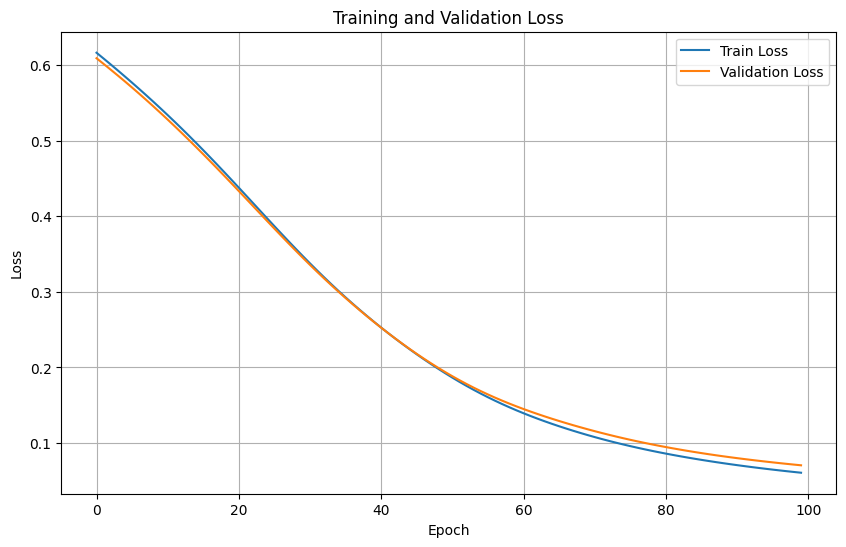

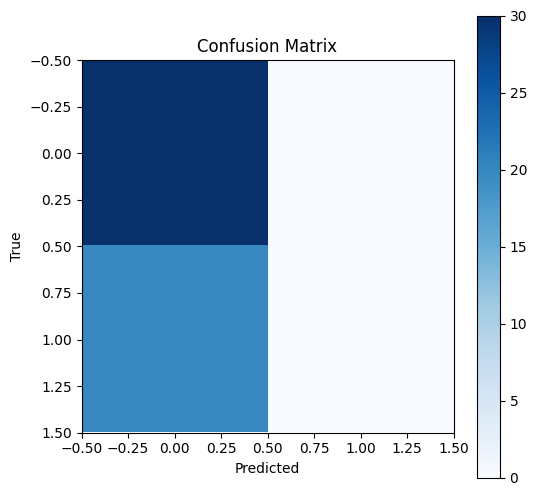

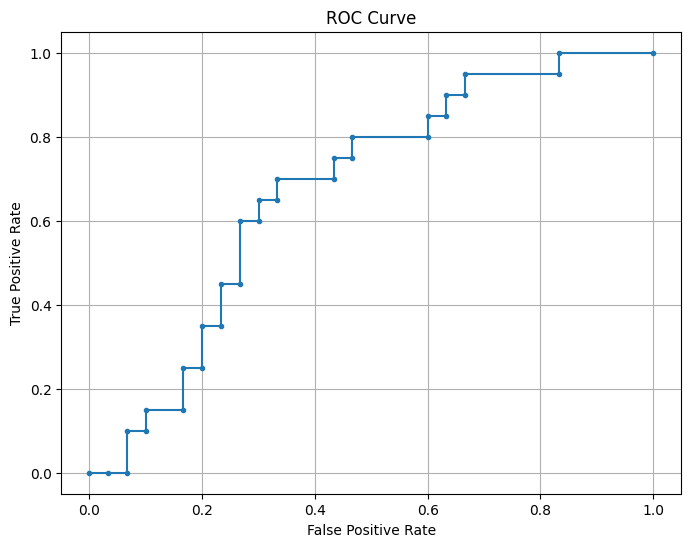

In [67]:
# Load the best model
model.load_state_dict(torch.load('/data/servilla/DT_HGNN/data/Models_saves/best_model.pth'))

# Test the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    out = model(data.x_dict, data.edge_index_dict, test_edges_tp_s)  # Get model predictions
    test_loss = criterion(out, test_labels_tp_s)
    test_accuracy, test_precision, test_recall, test_f1, test_auc = calculate_metrics(test_labels_tp_s, out)

# Print test metrics
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
      f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, "
      f"Test F1: {test_f1:.4f}, Test AUC: {test_auc:.4f}")




# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('/data/servilla/DT_HGNN/Plots/loss_plot.png')
plt.show()

from sklearn.metrics import confusion_matrix, roc_curve

# Plot Confusion Matrix
def plot_confusion_matrix(labels, preds):
    preds_binary = (preds > 0.5).astype(int)
    cm = confusion_matrix(labels, preds_binary)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('/data/servilla/DT_HGNN/Plots/confusion_matrix.png')
    plt.show()

# Plot ROC Curve
def plot_roc_curve(labels, preds):
    fpr, tpr, _ = roc_curve(labels, preds)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='.')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.savefig('/data/servilla/DT_HGNN/Plots/roc_curve.png')
    plt.show()

# After testing, plot confusion matrix and ROC curve
plot_confusion_matrix(test_labels_tp_s.cpu().numpy(), torch.sigmoid(out).cpu().numpy())
plot_roc_curve(test_labels_tp_s.cpu().numpy(), torch.sigmoid(out).cpu().numpy())
